In [1]:
import numpy as np
from meshplot import plot, subplot, interact
import igl
import scipy
import os
root_folder = os.getcwd()

In [22]:
from src.generate_mesh import triangular_lattice
from src.generate_mesh import create_mesh
from src.generate_mesh import linked_list_cell
from src.elastic_energy import Elastic_Local
from src.MC_vertex_link import MCstep_vertexB
from src.MC_vertex_link import MCstep_linkB

triangular_lattice = np.array( triangular_lattice(1.1, expansion_level =10) ) # returns a list with points on the Euclidean plane (2d space)
ver, TRI=create_mesh(triangular_lattice)
header,linklis,L=linked_list_cell(ver)
ev,et,te=igl.edge_topology(ver,TRI) #ev edges as pair of vertices, et triangle edge relation, te edge triangle relation, -1 for boundaries
gen=igl.adjacency_matrix(TRI)
neig=scipy.sparse.lil_matrix(gen) #lil more efficint sparse format

normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)
z=np.array([1/3,1/3,1/3])
z=z/np.linalg.norm(z)
normals_face=igl.per_face_normals(ver,TRI,z) #z normal given to degenerate faces(??)
area = igl.doublearea(ver, TRI) / 2.0
neigh=igl.adjacency_list(TRI)
ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))
border=igl.is_border_vertex(ver,TRI)

1
(-1.6500000000000001, 0.9526279441628825)
1
(-2.75, 0.9526279441628824)
2
(-2.2, 1.9052558883257649)
1
(-3.8500000000000005, 0.9526279441628825)
2
(-3.3000000000000003, 1.905255888325765)
3
(-2.75, 2.8578838324886475)
1
(-4.95, 0.9526279441628825)
2
(-4.4, 1.905255888325765)
3
(-3.8499999999999996, 2.857883832488648)
4
(-3.3, 3.81051177665153)
1
(-6.050000000000001, 0.9526279441628824)
2
(-5.5, 1.9052558883257649)
3
(-4.95, 2.8578838324886475)
4
(-4.4, 3.8105117766515297)
5
(-3.8500000000000005, 4.763139720814412)
1
(-7.150000000000001, 0.9526279441628824)
2
(-6.600000000000001, 1.9052558883257649)
3
(-6.050000000000001, 2.8578838324886475)
4
(-5.500000000000001, 3.8105117766515297)
5
(-4.950000000000001, 4.763139720814412)
6
(-4.4, 5.715767664977295)
1
(-8.25, 0.9526279441628825)
2
(-7.700000000000001, 1.905255888325765)
3
(-7.15, 2.8578838324886475)
4
(-6.6000000000000005, 3.81051177665153)
5
(-6.050000000000001, 4.763139720814412)
6
(-5.5, 5.715767664977295)
7
(-4.95, 6.6683956091

In [23]:
len(ver)

331

In [24]:
border=igl.is_border_vertex(ver,TRI)
ver_bulk=[]
for i in range(0,len(border)):
    if border[i]==False:
        ver_bulk.append(i)
    else:
        ver[i]=[ver[i][0],ver[i][1],0]
#ver[1]=[ver[1][0],ver[1][1],-1]

In [28]:
plot(ver,TRI)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [30]:
k=0.0000001
β=0.1
r=1.0
σ=0.1*r
normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)  
#if want updated ELastic Local need to calculate again normals ver which are not updated by MC
H,c1,c2,A_v,SHO=Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border)
H/k

552.5412628371301

In [257]:
#to check it updates Shape operator correctly
for i in range(0,len(ev)):
    if abs(SHO[0,0,i]-SHO2[0,0,i])>10e-10:
            print(SHO[0,0,i],SHO2[0,0,i]," ",i)
            print(SHO[:,:,i]," ",SHO2[:,:,i])

In [27]:
nlinks=0
nvert=0
for z in range(0,300): 
    H_new=MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,c1,c2,A_v,normals_face,ADJ,NI,neigh,et,ev,SHO,ver_bulk,border,area)
    H=H_new
    H_new,ADJ_new,NI_new=MCstep_linkB(ver,TRI,H,neig,β,c1,c2,k,r,ev,et,te,area,normals_face,ADJ,NI,SHO,border,A_v)
    H=H_new
    ADJ,NI=ADJ_new,NI_new
    neigh=igl.adjacency_list(TRI) #Can update locally in MCstep_link

In [29]:
H/k

552.5412628371337

In [241]:
%timeit MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,c1,c2,A_v,normals_face,ADJ,NI,neigh,et,ev,SHO,ver_bulk,border)

3.13 s ± 299 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
N  T #MCstep_vertex time
91  314 
397 1.73
721 3.13
1387 6.15

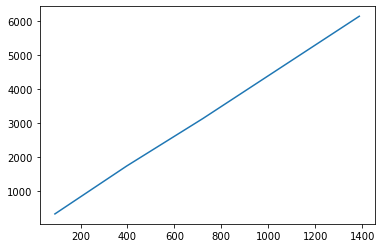

In [31]:
from matplotlib import pyplot as plt
plt.plot([91,397,721,1387],[314,1730,3130,6150])

In [133]:
%timeit update_energy_neig(ver,TRI,H,c1,c2,k,A_v,0,normals_face,neigh,ADJ,NI,area,SHO,et,border)

4.02 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
%timeit update_energy_vertex(ver,TRI,H,c1,c2,k,A_v,1,normals_face,neigh,ADJ,NI,area,SHO,et)

2.73 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
